In [1]:
#cnet_model.ipynb 
# 
#by Joe Hahn
#joe.hahn@oracle.com
#30 July 2018
#
#train a cnet layer on the XO dataset

In [2]:
#set system parameters
x_half_width = 0.5
radius = 3.5
box_half_width = 7.1
jitter = 1.0
rn_seed = 15
initial_id = 0

In [3]:
#start time
import time as tm
time_start = tm.time()

In [4]:
#generate balanced training data so that X class is 1.5x more abundant that O,B
N_dots = 26700
X_boost = 2.0
import numpy as np
rn_state = np.random.RandomState(seed=rn_seed)
from helper_fns import *
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
df = rebalance_df(df, X_boost=X_boost)
print df.groupby('class')['id'].count()
train = df
train.tail(5)

class
B    1877
O    1877
X    3755
Name: id, dtype: int64


,id,x,y,r,angle,class,X_score,O_score,B_score
7504,4533,-3.399884,-3.554062,4.918391,-2.334027,X,1.0,0.0,0.0
7505,10695,-3.155815,-1.110922,3.345641,-2.803116,O,0.0,1.0,0.0
7506,26280,-0.316713,3.732166,3.745580,1.655454,B,0.0,0.0,1.0
7507,24415,2.233011,2.915322,3.672253,0.917161,X,1.0,0.0,0.0
7508,23214,3.168384,3.793553,4.942641,0.874956,X,1.0,0.0,0.0


In [5]:
#select x-features and y = target variables = class-scores
x_cols = ['x', 'y']
y_cols = ['O_score', 'X_score', 'B_score']
x_train = train[x_cols].values
y_train = train[y_cols].values
print 'x_train.shape = ', x_train.shape
print 'y_train.shape = ', y_train.shape
x_train

x_train.shape =  (7509, 2)
y_train.shape =  (7509, 3)


array([[ 1.00089779,  1.20194923],
       [-3.37436177,  4.61100225],
       [ 0.37732668, -7.00425569],
       ..., 
       [-0.31671301,  3.73216611],
       [ 2.23301103,  2.91532176],
       [ 3.16838384,  3.7935535 ]])

In [6]:
#generate balanced validation data
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
df = rebalance_df(df)
print df.groupby('class')['id'].count()
x_val = df[x_cols].values
y_val = df[y_cols].values
print 'x_val.shape = ', x_val.shape
print 'y_val.shape = ', y_val.shape
y_val

class
B    3429
O    3429
X    3429
Name: id, dtype: int64
x_val.shape =  (10287, 2)
y_val.shape =  (10287, 3)


array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.]])

In [7]:
#set model properties
N_input = len(x_cols)
N_2d = 100
kernel_size = 6
N_output = len(y_cols)
output_activation_fn = 'sigmoid'
output_activation_fn = 'linear'

In [8]:
#build classifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Reshape, Conv2D, MaxPooling2D, Flatten
model = Sequential()
#input layer
input_shape = (N_input,)
N = N_2d**2
layer = Dense(N, activation='elu', input_shape=input_shape)
model.add(layer)
#reshape input layer
output_shape = (N_2d, N_2d, 1)
layer = Reshape(output_shape)
model.add(layer)
#add Conv2D + MaxPooling2D layers
layer = Conv2D(1, kernel_size=kernel_size, padding='same', activation='elu')
model.add(layer)
pool_size = kernel_size/2
layer = MaxPooling2D(pool_size=pool_size, strides=pool_size)
model.add(layer)
#add Conv2D + MaxPooling2D layers
layer = Conv2D(1, kernel_size=kernel_size, padding='same', activation='elu')
model.add(layer)
layer = MaxPooling2D(pool_size=pool_size, strides=pool_size)
model.add(layer)
#flatten + output layer
layer = Flatten()
model.add(layer)
model.add(Dense(N_output, activation=output_activation_fn))
#set loss function
if (output_activation_fn == 'linear'):
    loss_fn = 'mean_squared_error'
if (output_activation_fn == 'sigmoid'):
    loss_fn = 'categorical_crossentropy'
model.compile(loss=loss_fn, optimizer='adam')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10000)             30000     
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 1)       37        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 1)         37        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 121)               0         
__________

In [9]:
#train model
N_training_epochs = 25
batch_size = 2000
fit_history = model.fit(x_train, y_train, epochs=N_training_epochs, batch_size=batch_size, verbose=1,
    validation_data=(x_val, y_val))

Train on 7509 samples, validate on 10287 samples
Epoch 1/25
7509/7509 [==============================] - 44s 6ms/step - loss: 0.2781 - val_loss: 0.2223
Epoch 2/25
7509/7509 [==============================] - 45s 6ms/step - loss: 0.2004 - val_loss: 0.2085
Epoch 3/25
7509/7509 [==============================] - 45s 6ms/step - loss: 0.1829 - val_loss: 0.1930
Epoch 4/25
7509/7509 [==============================] - 45s 6ms/step - loss: 0.1728 - val_loss: 0.1837
Epoch 5/25
7509/7509 [==============================] - 46s 6ms/step - loss: 0.1637 - val_loss: 0.1773
Epoch 6/25
7509/7509 [==============================] - 46s 6ms/step - loss: 0.1556 - val_loss: 0.1667
Epoch 7/25
7509/7509 [==============================] - 46s 6ms/step - loss: 0.1502 - val_loss: 0.1628
Epoch 8/25
7509/7509 [==============================] - 46s 6ms/step - loss: 0.1461 - val_loss: 0.1617
Epoch 9/25
7509/7509 [==============================] - 49s 7ms/step - loss: 0.1441 - val_loss: 0.1588
Epoch 10/25
7509/7509 [=

In [10]:
#prep plots
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set(font_scale=1.5, font='DejaVu Sans')

final validation loss =  0.157203157807


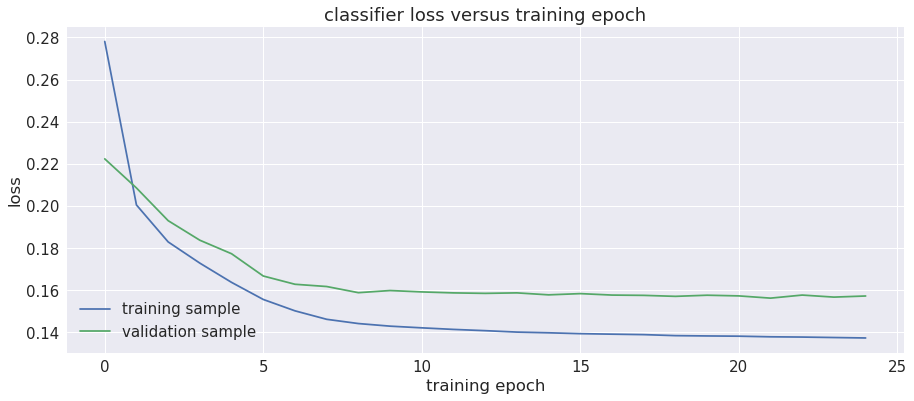

In [11]:
#plot accuracy vs training epoch
fig, ax = plt.subplots(1,1, figsize=(15, 6))
xp = fit_history.epoch
yp = fit_history.history['loss']
ax.plot(xp, yp, label='training sample')
yp = fit_history.history['val_loss']
ax.plot(xp, yp, label='validation sample')
ax.set_title('classifier loss versus training epoch')
ax.set_ylabel('loss')
ax.set_xlabel('training epoch')
ax.legend(loc='lower left')
#ax.set_ylim(0.95*np.min(yp), 1.05*np.max(yp[1:]))
plt.savefig('figs/mlp_loss.png')
print 'final validation loss = ', yp[-1]

In [12]:
#generate class predictions on testing X-O data
N_dots = 20000
df = make_xo_df(N_dots, initial_id, x_half_width, radius, box_half_width, jitter)
x = df[x_cols].values
y = df[y_cols].values
y_pred = model.predict(x)
for idx in range(len(y_cols)):
    y_col = y_cols[idx]
    df[y_col] = y_pred[:, idx]
idx = (df.O_score > df.X_score) & (df.O_score > df.B_score)
df.loc[idx, 'class_pred'] = 'O'
idx = (df.X_score > df.B_score) & (df.X_score > df.O_score)
df.loc[idx, 'class_pred'] = 'X'
idx = (df.B_score > df.O_score) & (df.B_score > df.X_score)
df.loc[idx, 'class_pred'] = 'B'
df.head(5)

,id,x,y,r,angle,class,X_score,O_score,B_score,class_pred
record,,,,,,,,,,
0,0,-0.446469,-6.628903,6.643921,-1.638047,B,-0.003143,0.107454,0.850934,B
1,1,-2.726761,-6.140451,6.718658,-1.988704,B,0.301840,0.026617,0.659525,B
2,2,-3.945419,-5.833560,7.042496,-2.165460,B,0.645347,-0.002849,0.343990,X
3,3,0.890983,-6.511481,6.572156,-1.434808,B,0.008110,0.149365,0.810513,B
4,4,1.990732,-0.968355,2.213759,-0.452734,O,0.516862,0.505344,-0.027024,X


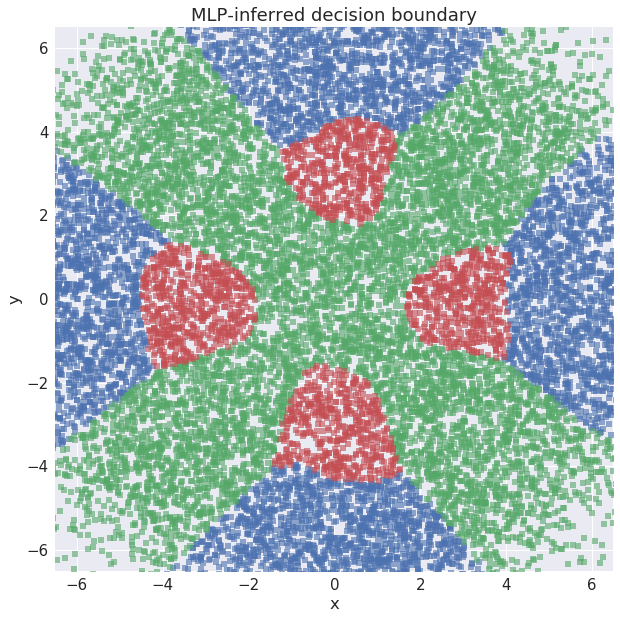

In [13]:
#scatterplot showing model's predicted decision boundaries
xy_rng = (-6.5, 6.5)
sz = 30
f, ax = plt.subplots(figsize=(10,10))
lbl = 'B'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'X'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
lbl = 'O'
idx = (df['class_pred'] == lbl)
xp = df[idx].x
yp = df[idx].y
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.6, 's': sz}, marker='s', label=lbl)
p = ax.set_title('MLP-inferred decision boundary')
p = ax.set_xlabel('x')
p = ax.set_ylabel('y')
p = ax.set_xlim(xy_rng)
p = ax.set_ylim(xy_rng)
plt.savefig('figs/cnet_decision_boundary.png')

In [14]:
#model accuracy
idx = (df['class'] == df['class_pred'])
accuracy = idx.sum()*1.0/len(idx)
print 'model accuracy = ', accuracy

model accuracy =  0.6527


In [15]:
#done
time_stop = tm.time()
print 'execution time (minutes) = ', (time_stop - time_start)/60.0

execution time (minutes) =  20.0253577828
